# LangGraphで作るAIエージェント実践入門

## 9.3 ハンズオン：Q&Aアプリケーション

In [1]:
import os


In [2]:
ROLES = {
    "1": {
        "name": "一般知識エキスパート",
        "description": "幅広い分野の一般的な質問に答える",
        "details": "幅広い分野の一般的な質問に対して、正確で分かりやすい回答を提供してください。",
    },
    "2": {
        "name": "生成AI製品エキスパート",
        "description": "生成AIや関連製品、技術に関する専門的な質問に答える",
        "details": "生成AIや関連製品、技術に関する専門的な質問に対して、最新の情報と深い洞察を提供してください。",
    },
    "3": {
        "name": "カウンセラー",
        "description": "個人的な悩みや心理的な問題に対してサポートを提供する",
        "details": "個人的な悩みや心理的な問題に対して、共感的で支援的な回答を提供し、可能であれば適切なアドバイスも行ってください。",
    },
}


In [3]:
import operator
from typing import Annotated

from pydantic import BaseModel, Field


class State(BaseModel):
    query: str = Field(..., description="ユーザーからの質問")
    current_role: str = Field(default="", description="選定された回答ロール")
    messages: Annotated[list[str], operator.add] = Field(default=[], description="回答履歴")
    current_judge: bool = Field(default=False, description="品質チェックの結果")
    judgement_reason: str = Field(default="", description="品質チェックの判定理由")


In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.runnables import ConfigurableField

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)
# 後からmax_tokensの値を変更できるように、変更可能なフィールドを宣言
llm = llm.configurable_fields(max_tokens=ConfigurableField(id="max_tokens"))


In [5]:
from typing import Any

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


def selection_node(state: State) -> dict[str, Any]:
    query = state.query
    role_options = "\n".join([f"{k}. {v['name']}: {v['description']}" for k, v in ROLES.items()])

    prompt = ChatPromptTemplate.from_template(
        """質問を分析し、最も適切な回答担当ロールを選択してください。

    選択肢:
    {role_options}

    回答は選択肢の番号（1、2、または3）のみを返してください。

    質問: {query}
    """.strip()
    )

    # 選択肢の番号のみを返すことを期待したいため、max_tokensの値を1に変更
    chain = prompt | llm.with_config(configurable=dict(max_tokens=1)) | StrOutputParser()
    role_number = chain.invoke({"role_options": role_options, "query": query})

    selected_role = ROLES[role_number.strip()]["name"]
    return {"current_role": selected_role}


In [6]:
def answering_node(state: State) -> dict[str, Any]:
    query = state.query
    role = state.current_role
    role_details = "\n".join([f"- {v['name']}: {v['details']}" for v in ROLES.values()])

    prompt = ChatPromptTemplate.from_template(
        """あなたは{role}として回答してください。以下の質問に対して、あなたの役割に基づいた適切な回答を提供してください。

    役割の詳細:
    {role_details}

    質問: {query}

    回答:""".strip()
    )

    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"role": role, "role_details": role_details, "query": query})

    return {"messages": [answer]}


In [7]:
class Judgement(BaseModel):
    judge: bool = Field(default=False, description="判定結果")
    reason: str = Field(default="", description="判定理由")


def check_node(state: State) -> dict[str, Any]:
    query = state.query
    answer = state.messages[-1]

    prompt = ChatPromptTemplate.from_template(
        """以下の回答の品質をチェックし、問題がある場合は'False'、問題がない場合は'True'を回答してください。
    また、その判断理由も説明してください。

    ユーザーからの質問: {query}
    回答: {answer}
    """.strip()
    )

    chain = prompt | llm.with_structured_output(Judgement)
    result: Judgement = chain.invoke({"query": query, "answer": answer})

    return {"current_judge": result.judge, "judgement_reason": result.reason}


In [8]:
from langgraph.graph import StateGraph

workflow = StateGraph(State)


In [9]:
workflow.add_node("selection", selection_node)
workflow.add_node("answering", answering_node)
workflow.add_node("check", check_node)


In [10]:
# selectionノードから処理を開始
workflow.set_entry_point("selection")


In [11]:
# selectionノードからansweringノードへ
workflow.add_edge("selection", "answering")
# answeringノードからcheckノードへ
workflow.add_edge("answering", "check")


In [12]:
from langgraph.graph import END

# checkノードから次のノードへの遷移に条件付きエッジを定義
# state.current_judgeの値がTrueならENDノードへ、Falseならselectionノードへ
workflow.add_conditional_edges("check", lambda state: state.current_judge, {True: END, False: "selection"})


In [13]:
compiled = workflow.compile()


In [14]:
initial_state = State(query="生成AIについて教えてください")
result = compiled.invoke(initial_state)


In [15]:
result


{'query': '生成AIについて教えてください',
 'current_role': '生成AI製品エキスパート',
 'messages': ['生成AIとは、人工知能の一分野であり、特にデータを基に新しいコンテンツを生成する能力を持つ技術を指します。これには、テキスト、画像、音声、動画など、さまざまな形式のコンテンツが含まれます。生成AIは、機械学習アルゴリズム、特に深層学習を利用して、既存のデータからパターンを学習し、それを基に新しいデータを生成します。\n\n### 主な技術と応用例\n\n1. **自然言語処理（NLP）**:\n   - テキスト生成（例: GPTシリーズ）\n   - 自動翻訳\n   - チャットボットやバーチャルアシスタント\n\n2. **画像生成**:\n   - GAN（Generative Adversarial Networks）を用いた画像生成（例: DALL-E、StyleGAN）\n   - 画像の修正やスタイル変換\n\n3. **音声生成**:\n   - テキストから音声を生成する技術（例: TTS: Text-to-Speech）\n   - 音楽の自動作曲\n\n4. **動画生成**:\n   - 動画の自動生成や編集\n   - アニメーションの作成\n\n### 利点と課題\n\n**利点**:\n- コンテンツ制作の効率化\n- 創造性の拡張\n- パーソナライズされた体験の提供\n\n**課題**:\n- 倫理的な問題（偽情報の生成、著作権の侵害など）\n- バイアスの問題（学習データに基づく偏り）\n- コンテンツの品質管理\n\n生成AIは、ビジネス、エンターテインメント、教育など、さまざまな分野での応用が進んでおり、今後もその可能性は広がっていくと考えられています。'],
 'current_judge': True,
 'judgement_reason': '回答は生成AIについての基本的な定義、主な技術と応用例、利点と課題を包括的に説明しており、情報が正確で関連性が高い。'}

In [16]:
print(result["messages"][-1])


生成AIとは、人工知能の一分野であり、特にデータを基に新しいコンテンツを生成する能力を持つ技術を指します。これには、テキスト、画像、音声、動画など、さまざまな形式のコンテンツが含まれます。生成AIは、機械学習アルゴリズム、特に深層学習を利用して、既存のデータからパターンを学習し、それを基に新しいデータを生成します。

### 主な技術と応用例

1. **自然言語処理（NLP）**:
   - テキスト生成（例: GPTシリーズ）
   - 自動翻訳
   - チャットボットやバーチャルアシスタント

2. **画像生成**:
   - GAN（Generative Adversarial Networks）を用いた画像生成（例: DALL-E、StyleGAN）
   - 画像の修正やスタイル変換

3. **音声生成**:
   - テキストから音声を生成する技術（例: TTS: Text-to-Speech）
   - 音楽の自動作曲

4. **動画生成**:
   - 動画の自動生成や編集
   - アニメーションの作成

### 利点と課題

**利点**:
- コンテンツ制作の効率化
- 創造性の拡張
- パーソナライズされた体験の提供

**課題**:
- 倫理的な問題（偽情報の生成、著作権の侵害など）
- バイアスの問題（学習データに基づく偏り）
- コンテンツの品質管理

生成AIは、ビジネス、エンターテインメント、教育など、さまざまな分野での応用が進んでおり、今後もその可能性は広がっていくと考えられています。


In [22]:
initial_state = State(query="生成AIについて教えてください")
result = await compiled.ainvoke(initial_state)
result


Error in LangChainTracer.on_chain_start callback: ValidationError(model='Run', errors=[{'loc': ('__root__',), 'msg': "argument of type 'NoneType' is not iterable", 'type': 'type_error'}])
Error in LangChainTracer.on_chain_end callback: TracerException('No indexed run ID 876d06ed-7e30-4646-8566-010d981147f0.')


{'query': '生成AIについて教えてください',
 'current_role': '生成AI製品エキスパート',
 'messages': ['生成AIとは、人工知能の一分野であり、特にデータを基に新しいコンテンツを生成する能力を持つ技術を指します。これには、テキスト、画像、音声、動画など、さまざまな形式のコンテンツが含まれます。生成AIは、機械学習アルゴリズム、特に深層学習を利用して、既存のデータからパターンを学習し、それを基に新しいデータを生成します。\n\n### 主な技術とモデル\n1. **自然言語処理（NLP）**: テキスト生成に特化したモデル（例: GPTシリーズ、BERTなど）があり、文章の作成、要約、翻訳などに利用されます。\n2. **画像生成**: GAN（Generative Adversarial Networks）やVQ-VAEなどの技術を用いて、リアルな画像を生成することができます。例としては、DALL-EやMidjourneyがあります。\n3. **音声生成**: 音声合成技術を用いて、自然な音声を生成することが可能です。これには、音声のトーンやスタイルを調整することも含まれます。\n\n### 利用例\n- **コンテンツ制作**: ブログ記事、広告コピー、ストーリーなどの自動生成。\n- **アートとデザイン**: アート作品やデザインの生成、カスタマイズ。\n- **ゲーム開発**: ゲーム内のキャラクターやストーリーの生成。\n- **教育**: 学習教材や問題集の自動生成。\n\n### 課題と倫理\n生成AIには、著作権やプライバシーの問題、フェイクニュースの生成、バイアスの問題など、さまざまな倫理的課題が伴います。これらの課題に対処するために、開発者や企業は責任あるAIの使用を促進するためのガイドラインや規制を設ける必要があります。\n\n生成AIは、今後の技術革新において重要な役割を果たすと期待されており、さまざまな分野での応用が進んでいます。'],
 'current_judge': True,
 'judgement_reason': '回答は生成AIについての基本的な定義、技術、利用例、課題と倫理に関する情報を包括的に提供しており、正確で関連性のある内容が含まれています。'}

In [ ]:
!apt-get install -y graphviz libgraphviz-dev pkg-config
!uv pip install pygraphviz


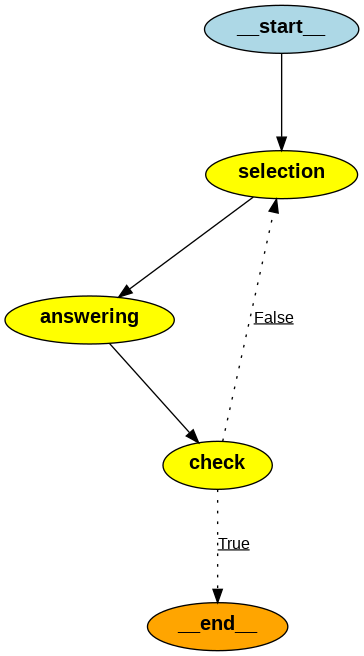

In [26]:
from IPython.display import Image

Image(compiled.get_graph().draw_png())


## 9.4 チェックポイント機能：ステートの永続化と再会

In [19]:
import operator
from typing import Annotated, Any
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field


# グラフのステートを定義
class State(BaseModel):
    query: str
    messages: Annotated[list[BaseMessage], operator.add] = Field(default=[])


# メッセージを追加するノード関数
def add_message(state: State) -> dict[str, Any]:
    additional_messages = []
    if not state.messages:
        additional_messages.append(SystemMessage(content="あなたは最小限の応答をする対話エージェントです。"))
    additional_messages.append(HumanMessage(content=state.query))
    return {"messages": additional_messages}


# LLMからの応答を追加するノード関数
def llm_response(state: State) -> dict[str, Any]:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
    ai_message = llm.invoke(state.messages)
    return {"messages": [ai_message]}


In [20]:
from pprint import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.base import BaseCheckpointSaver


def print_checkpoint_dump(checkpointer: BaseCheckpointSaver, config: RunnableConfig):
    checkpoint_tuple = checkpointer.get_tuple(config)

    print("チェックポイントデータ:")
    pprint(checkpoint_tuple.checkpoint)
    print("\nメタデータ:")
    pprint(checkpoint_tuple.metadata)


In [21]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# グラフを設定
graph = StateGraph(State)
graph.add_node("add_message", add_message)
graph.add_node("llm_response", llm_response)

graph.set_entry_point("add_message")
graph.add_edge("add_message", "llm_response")
graph.add_edge("llm_response", END)

# チェックポインターを設定
checkpointer = MemorySaver()

# グラフをコンパイル
compiled_graph = graph.compile(checkpointer=checkpointer)


In [22]:
config = {"configurable": {"thread_id": "example-1"}}
user_query = State(query="私の好きなものはずんだ餅です。覚えておいてね。")
first_response = compiled_graph.invoke(user_query, config)
first_response


{'query': '私の好きなものはずんだ餅です。覚えておいてね。',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 48, 'total_tokens': 62, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}, id='run-832540ae-acd7-4970-94d8-f6f9b7ddf3d5-0', usage_metadata={'input_tokens': 48, 'output_tokens': 14, 'total_tokens': 62})]}

In [23]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)


CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1efccb6a-fcb1-6e74-8002-f34d68a99950'}}, checkpoint={'v': 1, 'ts': '2025-01-07T05:17:27.721317+00:00', 'id': '1efccb6a-fcb1-6e74-8002-f34d68a99950', 'channel_values': {'query': '私の好きなものはずんだ餅です。覚えておいてね。', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='了解しました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 48, 'total_tokens': 62, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop',

In [24]:
print_checkpoint_dump(checkpointer, config)


チェックポイントデータ:
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 48, 'total_tokens': 62, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}, id='run-832540ae-acd7-4970-94d8-f6f9b7ddf3d5-0', usage_metadata={'input_tokens': 48, 'output_tokens': 14, 'total_tokens': 62})],
          

In [25]:
user_query = State(query="私の好物は何か覚えてる？")
second_response = compiled_graph.invoke(user_query, config)
second_response


{'query': '私の好物は何か覚えてる？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 48, 'total_tokens': 62, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}, id='run-832540ae-acd7-4970-94d8-f6f9b7ddf3d5-0', usage_metadata={'input_tokens': 48, 'output_tokens': 14, 'total_tokens': 62}),
  HumanMessage(content='私の好物は何か覚えてる？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='はい、ずんだ餅ですね。', additional_k

In [26]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)


CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1efccb75-b49b-632f-8006-7832c12b5afc'}}, checkpoint={'v': 1, 'ts': '2025-01-07T05:22:15.441272+00:00', 'id': '1efccb75-b49b-632f-8006-7832c12b5afc', 'channel_values': {'query': '私の好物は何か覚えてる？', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='了解しました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 48, 'total_tokens': 62, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs'

In [27]:
print_checkpoint_dump(checkpointer, config)


チェックポイントデータ:
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 48, 'total_tokens': 62, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}, id='run-832540ae-acd7-4970-94d8-f6f9b7ddf3d5-0', usage_metadata={'input_tokens': 48, 'output_tokens': 14, 'total_tokens': 62}),
           

In [28]:
config = {"configurable": {"thread_id": "example-2"}}
user_query = State(query="私の好物は何？")
other_thread_response = compiled_graph.invoke(user_query, config)
other_thread_response


{'query': '私の好物は何？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好物は何？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='わかりません。あなたの好物は何ですか？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 36, 'total_tokens': 51, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-564e00f9-e655-4606-aa27-0fcd0ac97ae4-0', usage_metadata={'input_tokens': 36, 'output_tokens': 15, 'total_tokens': 51})]}